In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Set random seed 
RSEED = 100

In [5]:
# Load Training Data

train_data = pd.read_csv("../00_Data_Sets/1_mio_dataset_2010_2014.csv");
test_data = pd.read_csv("../00_Data_Sets/100_k_dataset_2015.csv");

In [6]:
# Load Input Data
incoming_data_passenger_count_outlier = pd.read_csv("../01_Synthetic Data/02_Passenger Count/passenger count_outlier_01.csv");
# incoming_data_location_outlier = pd.read_csv("../01_Synthetic Data/01_Location/location_outlier_01.csv");
# incoming_data_distance_outlier = pd.read_csv("../01_Synthetic Data/03_Distance/distance_outlier_01.csv");
# incoming_data_distance_drift = pd.read_csv("../01_Synthetic Data/03_Distance/distance_drift_total_01.csv");
# incoming_data_location_drift = pd.read_csv("../01_Synthetic Data/01_Location/location_drift_total.csv");
incoming_data_passenger_drift = pd.read_csv("../01_Synthetic Data/02_Passenger Count/passenger count_drift_total_01.csv");

In [7]:
# df = incoming_data_passenger_count_outlier.head(608)
# df = df[df.groupby('fare-bin')['fare-bin'].transform(len) > 1]
# df = prepare_incoming_batch(df, 0, 608);
# df['fare-bin'].value_counts()
# df.reset_index()

In [8]:
def monitor_drift_main_metrics(training_data, incoming_batch, start_index, end_index, batch_info, column, thresholds):
    
    batch_thresholds = thresholds[batch_info['name'].lower() + '_batch_drift']
    threshold = batch_thresholds['one_dim_drift_metric']
            
    if abs(incoming_batch.iloc[start_index:end_index,column].mean()) > abs((training_data.iloc[:,column].mean() * (1 + threshold))):
        print('[DRIFT][{} Window]: Upwards Data Drift detected!. ({} AVG: {})\t(Index: {})'.format(batch_info['name'], training_data.columns[column], incoming_batch.iloc[start_index:end_index,column].mean(), end_index))
        
    if abs(incoming_batch.iloc[start_index:end_index,column].quantile(0.25)) > abs((training_data.iloc[:,column].quantile(0.25) * (1 + threshold))):
        print('[DRIFT][{} Window]: Upwards Data Drift detected! ({} 25%-Quantile: {})\t(Index: {})'.format(batch_info['name'], training_data.columns[column], incoming_batch.iloc[start_index:end_index,column].mean(), end_index))
        
    if abs(incoming_batch.iloc[start_index:end_index,column].quantile(0.75)) > abs((training_data.iloc[:,column].quantile(0.75) * (1 + threshold))):
        print('[DRIFT][{} Window]: Upwards Data Drift detected! ({} 75%-Quantile: {})\t(Index: {})'.format(batch_info['name'], training_data.columns[column], incoming_batch.iloc[start_index:end_index,column].mean(), end_index))
        
    if abs(incoming_batch.iloc[start_index:end_index,column].mean()) < abs((training_data.iloc[:,column].mean() * (1 - threshold))):
        print('[DRIFT][{} Window]: Downwards Data Drift detected! ({} AVG: {})\t(Index: {})'.format(batch_info['name'], training_data.columns[column], incoming_batch.iloc[start_index:end_index,column].mean(), end_index))
        
    if abs(incoming_batch.iloc[start_index:end_index,column].quantile(0.25)) < abs((training_data.iloc[:,column].quantile(0.25) * (1 - threshold))):
        print('[DRIFT][{} Window]: Downwards Data Drift detected! ({} 25%-Quantile: {})\t(Index: {})'.format(batch_info['name'], training_data.columns[column], incoming_batch.iloc[start_index:end_index,column].mean(), end_index))
        
    if abs(incoming_batch.iloc[start_index:end_index,column].quantile(0.75)) < abs((training_data.iloc[:,column].quantile(0.75) * (1 - threshold))):
        print('[DRIFT][{} Window]: Downwards Data Drift detected! ({} 75%-Quantile: {})\t(Index: {})'.format(batch_info['name'], training_data.columns[column], incoming_batch.iloc[start_index:end_index,column].mean(), end_index))

        
from math import log2

def kl_divergence(p, q):
    return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

        
def monitor_drift_kl_divergence(training_data, incoming_batch, start_index, end_index, batch_info, column, thresholds):
    
    batch_thresholds = thresholds[batch_info['name'].lower() + '_batch_drift']
    threshold = batch_thresholds['one_dim_drift_kl_divergence']
    
    # Filter out zero values in datasets
    batch_df = incoming_batch[incoming_batch.iloc[:,column] != 0]
    train_df = training_data[training_data.iloc[:,column] != 0]
    
    # Filter out negative values in dataset, if mean is positive (= remove negative outliers)
    if batch_df.iloc[:,column].mean() > 0:
        batch_df = batch_df[batch_df.iloc[:,column] > 0]
        
    batch_df = batch_df.reset_index()
    train_df = train_df.reset_index()
    batch_df = batch_df.drop('index', axis=1)
    train_df = train_df.drop('index', axis=1)
    batch = batch_df.iloc[start_index:end_index,column]
    batch = batch.reset_index()
    batch = batch.drop('index', axis=1)
    batch = batch.iloc[:,0]
    train = train_df.iloc[:,column]
    
    divergence_score = kl_divergence(batch, train);
    
    if divergence_score > threshold:
        print('[DRIFT][{} Window]: KL-Divergence detected! ({} Divergence: {})\t(Index: {})'.format(batch_info['name'], batch_df.columns[column], divergence_score, end_index))        
        

from scipy.stats import wasserstein_distance

def monitor_drift_wasserstein_distance(training_data, incoming_batch, start_index, end_index, batch_info, column, thresholds):
    
    batch_thresholds = thresholds[batch_info['name'].lower() + '_batch_drift']
    threshold = batch_thresholds['one_dim_drift_wasserstein']
    
    batch = incoming_batch.iloc[start_index:end_index, column]
    train = training_data.iloc[:, column]
    wasserstein_dist = wasserstein_distance(batch, train);
    
    if wasserstein_dist > threshold:
        print('[DRIFT][{} Window]: Great Wasserstein Distance detected! ({} Distance: {})\t(Index: {})'.format(batch_info['name'], incoming_batch.columns[column], wasserstein_dist, end_index))
        
def monitor_drift_pairwise_correlations(training_data, incoming_batch, start_index, end_index, batch_info, input_columns, train_pairwise_correlations, thresholds):
    batch_thresholds = thresholds[batch_info['name'].lower() + '_batch_drift']
    threshold = batch_thresholds['one_dim_drift_correlations']
    
    batch_pairwise_correlations = get_pairwise_correlations(incoming_batch.iloc[start_index:end_index,:], input_columns);
    
    for key in train_pairwise_correlations:
        for metric in range(0,1):
            distance = abs((train_pairwise_correlations[key][metric] - batch_pairwise_correlations[key][metric]))
            if distance > abs((train_pairwise_correlations[key][metric] * threshold)):
                print('[DRIFT][{} Window]: Pairwise Correlation Drift detected: {}!\t(Index: {})'.format(batch_info['name'], key, end_index))

    
def prepare_incoming_batch(data, start_index, end_index):
    # Remove fare-bin values with less occurences than 3; Avoid error in split data set
    df = data.iloc[start_index:end_index,:]
    df = df[df.groupby('fare-bin')['fare-bin'].transform(len) > 3]
    return df
    
def monitor_feature_importances(training_data, incoming_batch, start_index, end_index, batch_info, input_columns, feature_importances, thresholds):
    batch_thresholds = thresholds[batch_info['name'].lower() + '_batch_drift']
    threshold = batch_thresholds['one_dim_drift_feature_importances']
    
    incoming_batch = prepare_incoming_batch(incoming_batch, start_index, end_index);
  
    rf = get_rf(incoming_batch, input_columns);
    batch_feature_importance_list = rf.feature_importances_
    train_feature_importance_list = feature_importances
    feature_count = len(batch_feature_importance_list)
    
    for index in range(0, feature_count):
        if batch_feature_importance_list[index] > (train_feature_importance_list[index] * (1 + threshold)):
            print('[DRIFT][{} Window]: Feature Importance Drift detected for {}!\t(Index: {})'.format(batch_info['name'], incoming_batch.columns[input_columns[index]], end_index))
            
        if batch_feature_importance_list[index] < (train_feature_importance_list[index] / (1 + threshold)):
            print('[DRIFT][{} Window]: Feature Importance Drift detected for {}!\t(Index: {})'.format(batch_info['name'], incoming_batch.columns[input_columns[index]], end_index))

def monitor_drift_shap(train_data_infos, incoming_batch, start_index, end_index, batch_info, column, shap_index, thresholds):
    batch_thresholds = thresholds[batch_info['name'].lower() + '_batch_drift']
    threshold = batch_thresholds['one_dim_drift_shap']
    shap = get_shap_feature_importances(incoming_batch.iloc[start_index:end_index,:], train_data_infos['rf'], train_data_infos['input_columns'], thresholds)

    # SHAP Mean
    if shap[1][shap_index] < (train_data_infos['shap']['mean'][shap_index] * (1 - threshold)):
        print('[DRIFT][{} Window]: Downwards Shap Drift detected for {}!\t(Index: {})'.format(batch_info['name'], train_data.columns[column], end_index));    
        
    # SHAP Mean
    if shap[1][shap_index] > (train_data_infos['shap']['mean'][shap_index] * (1 + threshold)):
        print('[DRIFT][{} Window]: Upwards Shap Drift detected for {}!\t(Index: {})'.format(batch_info['name'], train_data.columns[column], end_index));            

def monitor_drift_one_dimension(training_data, train_data_infos, incoming_batch, start_index, end_index, batch_info, thresholds):
    input_columns = train_data_infos['input_columns']
    output_columns = train_data_infos['output_columns']
    columns_to_use = np.concatenate((output_columns, input_columns), axis=0)
    train_pairwise_correlations = train_data_infos['correlation_pairs']
    shap_index = 0
    
    for column in columns_to_use:
        monitor_drift_main_metrics(training_data, incoming_batch, start_index, end_index, batch_info, column, thresholds);
        monitor_drift_kl_divergence(training_data, incoming_batch, start_index, end_index, batch_info, column, thresholds);
        monitor_drift_wasserstein_distance(training_data, incoming_batch, start_index, end_index, batch_info, column, thresholds);
        # +++ SHAP IS COMMENTED OUT FOR PERFORMANCE REASONS +++
        # if column in input_columns:
            # monitor_drift_shap(train_data_infos, incoming_batch, start_index, end_index, batch_info, column, shap_index, thresholds);
            # shap_index = shap_index + 1
        
    monitor_drift_pairwise_correlations(training_data, incoming_batch, start_index, end_index, batch_info, input_columns, train_pairwise_correlations, thresholds);
    monitor_feature_importances(training_data, incoming_batch, start_index, end_index, batch_info, input_columns, train_data_infos['rf_feature_importances'], thresholds);
    
def monitor_drift_multi_dimensions(training_data, train_data_infos, incoming_batch, start_index, end_index, batch_info, thresholds):
    input_columns = train_data_infos['input_columns'];
    output_columns = train_data_infos['output_columns'];
    pca_model = train_data_infos['pca_model'];
    
    incoming_batch_filtered = get_data_filtered(incoming_batch, input_columns);
    incoming_batch_transformed = transform_pca(pca_model, incoming_batch_filtered);
    distances = calculate_euclidean_distances(incoming_batch_transformed, input_columns);
    distances_metrics = get_distance_metrics(distances, thresholds);
    
    if distances_metrics['mean'] > train_data_infos['distance_metrics']['mean']:
        print('[DRIFT][{} Window]: Multi-Dimensional Drift Detected! Mean Distance: {}\t\t\t(Index: {})'.format(batch_info['name'], distances_metrics['maximum'], end_index));
        
    if distances_metrics['first_quarter'] > train_data_infos['distance_metrics']['first_quarter']:
        print('[DRIFT][{} Window]: Multi-Dimensional Drift Detected! Distance: {}\t\t\t(Index: {})'.format(batch_info['name'], distances_metrics['first_quarter'], end_index));
        
    if distances_metrics['third_quarter'] > train_data_infos['distance_metrics']['third_quarter']:
        print('[DRIFT][{} Window]: Multi-Dimensional Drift Detected! Distance: {}\t\t\t(Index: {})'.format(batch_info['name'], distances_metrics['third_quarter'], end_index));
        
        
def monitor_batch_drift(training_data, train_data_infos, incoming_batch, index, batch_info, thresholds):
    batch_size = batch_info['size'];
    start_index = index - batch_size + 1;
    end_index = index;
    
    monitor_drift_one_dimension(training_data, train_data_infos, incoming_batch, start_index, end_index, batch_info, thresholds);
    monitor_drift_multi_dimensions(training_data, train_data_infos, incoming_batch, start_index, end_index, batch_info, thresholds);
    
def monitor_drift(training_data, train_data_infos, batch, step_sizes, index, row, batch_infos, thresholds):
    
    # Add new sample to batch
    batch.loc[index] = row.values;
        
    if batch.shape[0] % step_sizes['small'] == 0 and batch.shape[0] > (step_sizes['small']):
        monitor_batch_drift(training_data, train_data_infos, batch, index, batch_infos['small'], thresholds);

    if batch.shape[0] % step_sizes['medium'] == 0:
        monitor_batch_drift(training_data, train_data_infos, batch, index, batch_infos['medium'], thresholds);

    if batch.shape[0] % step_sizes['large'] == 0:
        monitor_batch_drift(training_data, train_data_infos, batch, index, batch_infos['large'], thresholds);

In [9]:
def get_rf(data, columns):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    
    # Split data
    X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                          stratify = data['fare-bin'], test_size=0.33,
                                                          random_state = RSEED)

    # Create the random forest        
    rf = RandomForestRegressor(n_estimators = 20, max_depth = 20, max_features = None, oob_score = True, 
                                bootstrap = True, verbose = 1, n_jobs = -1)

    # Train random forest
    column_list = []
    for column in columns:
        column_list.append(train_data.columns[column])
        
    rf.fit(X_train[column_list], y_train)
    
    return rf

In [10]:
# SAVE RF

# from sklearn.externals import joblib

# input_columns = [3, 4, 5, 6, 7, 12, 13, 14]
# rf = get_rf(train_data, input_columns)

# filename = 'rf.sav'
# joblib.dump(rf, filename);

In [11]:
def get_avg_samples_per_day(data):
    # TODO: More elegant solution possible?
    df = pd.DataFrame();
    df['pickup_datetime'] = train_data['pickup_datetime']
    df['count'] = 1
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df.index = df['pickup_datetime'] 
    df = df.resample('D').sum()
    df = df[df['count'] != 0]
    return df['count'].mean()

def get_batch_infos(data):
    batch_size_day = get_avg_samples_per_day(data);
    batch_size_week = batch_size_day * 7;
    batch_size_month = batch_size_day * 30;
    
    batch_sizes = {
        'small': {'size': int(batch_size_day), 'name': 'Small'},
        'medium': {'size': int(batch_size_week), 'name': 'Medium'},
        'large': {'size': int(batch_size_month), 'name': 'Large'},        
    }
    
    return batch_sizes;

def get_step_sizes(batch_infos):
    
    step_sizes = {
        'small': (batch_infos['small']['size'] / 2),
        'medium': (batch_infos['medium']['size'] / 2),
        'large': (batch_infos['large']['size'] / 2) 
    }
    return step_sizes;

def get_data_filtered(data, columns_to_use):
    data_filtered = pd.DataFrame()
    i = 0

    # Filter Input Columns
    for column in columns_to_use:
        data_filtered.insert(i, data.columns[column], data.iloc[:,column])
        i = i + 1
        
    return data_filtered;

def apply_pca(train_data_filtered):
    pca_model = get_pca_model(train_data_filtered);
    return pca_model, transform_pca(pca_model, train_data_filtered);

def get_pca_model(train_data_filtered):
    from sklearn.decomposition import PCA
    
    pca = PCA(whiten=True)
    return pca.fit(train_data_filtered)

def transform_pca(pca_model, train_data_filtered):
    from sklearn.decomposition import PCA
    
    return pca_model.transform(train_data_filtered)

def get_zero_vector(columns_to_use):
    number_of_dimensions = len(columns_to_use)
    return np.zeros((number_of_dimensions)*1)

def calculate_euclidean_distance(sample, zero_vector):
    from scipy.spatial import distance
    
    return distance.euclidean(sample, zero_vector)

def calculate_euclidean_distances(transformed_data, columns_to_use):
    from scipy.spatial import distance
    
    zero_vector = get_zero_vector(columns_to_use);
    
    index = 0
    distances = np.ndarray(shape=(np.size(transformed_data,0),1))

    # Create distances to zero vector
    for sample in transformed_data:
        distances[index] = calculate_euclidean_distance(transformed_data[index], zero_vector);
        index = index + 1
        
    return distances;

def get_pairwise_correlations(data, input_columns):
    
    from scipy.stats.stats import pearsonr
    import itertools
    
    pairwise_correlations = {}

    for column_a, column_b in itertools.combinations(input_columns, 2):
        correlation = pearsonr(data.iloc[:,column_a], data.iloc[:,column_b])
        pairwise_correlations['{} <> {}'.format(data.columns[column_a], data.columns[column_b])] = correlation
        
    return pairwise_correlations


def get_shap_feature_importances(data, rf, input_columns, thresholds):
    import shap
    raw_threshold = thresholds['one_dim_outlier']
    threshold =     raw_threshold * 1000

    column_list = []
    for column in input_columns:
        column_list.append(train_data.columns[column])

    explainer = shap.TreeExplainer(rf);
    shap_values = explainer.shap_values(data[column_list]);

    shap_values_lower_quantile = []
    shap_values_mean = []
    shap_values_upper_quantile = []

    for column in range(0, len(input_columns)):    
        shap_values_lower_quantile.append(np.percentile(shap_values[:,column], threshold))
        shap_values_mean.append(shap_values[:,column].mean())
        shap_values_upper_quantile.append(np.percentile(shap_values[:,column], (100 - threshold)))
        
    shap = [shap_values_lower_quantile, shap_values_mean, shap_values_upper_quantile]
    return shap
    

def get_distance_metrics(distances, thresholds):
    
    raw_threshold = thresholds['multi_dim_outlier']
    threshold = raw_threshold * 100
    
    distance_metrics = {
        'minimum': distances.min(),
        'lower_threshold_percentile': np.percentile(distances, threshold),
        'first_quarter': np.percentile(distances, 25),
        'mean': distances.mean(),
        'third_quarter': np.percentile(distances, 75),
        'upper_threshold_percentile': np.percentile(distances, (100 - threshold)),
        'maximum': distances.max()
    }
        
    return distance_metrics
    

def get_train_data_infos(distances, correlation_pairs, shap, rf, input_columns, output_columns, pca_model, thresholds):
    
    train_data_infos = {
        'input_columns': input_columns,
        'output_columns': output_columns,
        'pca_model': pca_model,
        'rf': rf,
        'rf_feature_importances': rf.feature_importances_,
        'shap': {
            'lower_threshold_percentile': shap[0],
            'mean': shap[1],
            'upper_threshold_percentile': shap[2]
        },
        'correlation_pairs': correlation_pairs,
        'distance_metrics': get_distance_metrics(distances, thresholds)
    }
    
    return train_data_infos;

def generate_train_data_infos(train_data, input_columns, output_columns, thresholds):
    # +++ REMOVE: Only for testing purposes +++
    from sklearn.externals import joblib
    rf = joblib.load('rf.sav')
    test = {
        'input_columns': input_columns,
        'output_columns': output_columns,
        'pca_model': get_pca_model(get_data_filtered(train_data, input_columns)),
        'rf': rf,
        'rf_feature_importances': rf.feature_importances_,
        'shap': {
            'lower_threshold_percentile': [-0.9627528245137031, -0.8588506007810717, -1.0228424799213929, -2.733344036928182, -0.21071108860192908, -0.7614152862846567, -7.004810823869412, -0.9397471843701778],
            'mean': [0.05859532547100909, 0.1150723753541944, 0.2375574423112044, -0.21863576089415065, 0.0049141129696212635, 0.18305498308684381, -0.6148760801903526, 0.16000324432733556],
            'upper_threshold_percentile': [2.984288788547222, 1.204538253875003, 4.797235571183871, 2.647309409210014, 0.2712167705821321, 1.3335546007529564, 36.2736142158481, 2.2940476694834837]
        },
        'correlation_pairs': get_pairwise_correlations(train_data, input_columns),
        'distance_metrics': {
            'minimum': 0.7249817600534729, 
            'lower_threshold_percentile': 1.0764902427267176,
            'first_quarter': 1.1133579226848411,
            'mean': 1.922411839793231,
            'third_quarter': 2.200820905397247,
            'upper_threshold_percentile': 8.095414750208105, 
            'maximum': 58.320576749831
        }
    }
    return test
    # +++ REMOVE: Only for testing purposes +++

    train_data_filtered = get_data_filtered(train_data, input_columns);
    pca_model, transformed_data = apply_pca(train_data_filtered);
    distances = calculate_euclidean_distances(transformed_data, input_columns);
    correlation_pairs = get_pairwise_correlations(train_data, input_columns);
    rf = get_rf(train_data, input_columns);
    shap = get_shap_feature_importances(train_data, rf, input_columns, thresholds);
    
    return get_train_data_infos(distances, correlation_pairs, shap, rf, input_columns, output_columns, pca_model, thresholds);  

In [12]:
def monitor_outliers_one_dimension(train_data, train_data_infos, incoming_sample, index, thresholds):
    
    threshold = thresholds['one_dim_outlier']
    input_columns = train_data_infos['input_columns']
    output_columns = train_data_infos['output_columns']
    columns_to_use = np.concatenate((output_columns, input_columns), axis=0) 
    shap = get_shap_feature_importances(pd.DataFrame(incoming_sample).transpose(), train_data_infos['rf'], input_columns, thresholds)
    shap_index = 0
    
    for column in columns_to_use:
            
            if incoming_sample[column] > train_data.iloc[:,column].max():
                print('[OUTLIER] MAX Outlier Detected! {}: {}\t\t\t(Index: {})'.format(train_data.columns[column], incoming_sample[column], index));

            elif incoming_sample[column] > train_data.iloc[:,column].quantile(1 - threshold):
                print('[POT. OUTLIER] Potential MAX Outlier Detected! {}: {}\t\t\t(Index: {})'.format(train_data.columns[column], incoming_sample[column], index));

            if incoming_sample[column] < train_data.iloc[:,column].min():
                print('[OUTLIER] MIN Outlier Detected! {}: {}\t\t\t(Index: {})'.format(train_data.columns[column], incoming_sample[column], index));
                
            elif incoming_sample[column] < train_data.iloc[:,column].quantile(threshold):
                print('[POT. OUTLIER] Potential MIN Outlier Detected! {}: {}\t\t\t(Index: {})'.format(train_data.columns[column], incoming_sample[column], index));
                
            if column in input_columns:
            
                # SHAP Lower Percentile
                if shap[0][shap_index] < train_data_infos['shap']['lower_threshold_percentile'][shap_index]:
                    print('[POT. MIN OUTLIER] Potential Shap Outlier Detected! {}\t\t\t(Index: {})'.format(train_data.columns[column], index));

                # SHAP Upper Percentile
                if shap[2][shap_index] > train_data_infos['shap']['upper_threshold_percentile'][shap_index]:
                    print('[POT. MAX OUTLIER] Potential Shap Outlier Detected! {}\t\t\t(Index: {})'.format(train_data.columns[column], index));

                shap_index = shap_index + 1

    
def monitor_outliers_multi_dimensions(train_data, train_data_infos, incoming_sample, index):
    incoming_sample_df = pd.DataFrame(incoming_sample).transpose();
    incoming_sample_df_filtered = get_data_filtered(incoming_sample_df, train_data_infos['input_columns']);
    incoming_sample_df_transformed = transform_pca(train_data_infos['pca_model'], incoming_sample_df_filtered);
    distance = calculate_euclidean_distance(incoming_sample_df_transformed, get_zero_vector(train_data_infos['input_columns']));

    if distance > train_data_infos['distance_metrics']['maximum']:
        print('[OUTLIER] Multi-Dimensional Outlier Detected! Distance: {}\t\t\t(Index: {})'.format(distance, index));
        
    elif distance > train_data_infos['distance_metrics']['upper_threshold_percentile']:
        print('[POT. OUTLIER] Potential Multi-Dimensional Outlier Detected! Distance: {}\t\t\t(Index: {})'.format(distance, index));

def monitor_outliers(train_data, train_data_infos, incoming_sample, index, thresholds):
    monitor_outliers_one_dimension(train_data, train_data_infos, incoming_sample, index, thresholds);
    monitor_outliers_multi_dimensions(train_data, train_data_infos, incoming_sample, index);

In [13]:
# Define desired thresholds

def get_thresholds():
    thresholds = {
        'one_dim_outlier': 0.001,
        'multi_dim_outlier': 0.1,
        'small_batch_drift': {
            'one_dim_drift_metric': 0.2,
            'one_dim_drift_kl_divergence': 6000,
            'one_dim_drift_wasserstein': 1.2,
            'one_dim_drift_correlations': 50,
            'one_dim_drift_feature_importances': 25,
            'one_dim_drift_shap': 5
        },
        'medium_batch_drift': {
            'one_dim_drift_metric': 0.1,
            'one_dim_drift_kl_divergence': 1000,
            'one_dim_drift_wasserstein': 0.25,
            'one_dim_drift_correlations': 20,
            'one_dim_drift_feature_importances': 20,
            'one_dim_drift_shap': 3            
        },
        'large_batch_drift': {
            'one_dim_drift_metric': 0.05,
            'one_dim_drift_kl_divergence': 500,
            'one_dim_drift_wasserstein': 0.2,
            'one_dim_drift_correlations': 15,
            'one_dim_drift_feature_importances': 15,
            'one_dim_drift_shap': 2           
        }
    }
    
    return thresholds;

In [14]:
# Needs to be configured individually
def prepare_data(data):
    prepared_data = data.copy()
    prepared_data['fare-bin'] = data.iloc[:,8].astype("category").cat.codes
    
    return prepared_data

In [15]:
def monitor(train_data, incoming_data):
        
    train_data = prepare_data(train_data);
    incoming_data = prepare_data(incoming_data);
    thresholds = get_thresholds();
    input_columns = [3, 4, 5, 6, 7, 12, 13, 14]
    output_columns = [1, 8]
    batch = pd.DataFrame(columns=incoming_data.columns);
    batch_infos = get_batch_infos(train_data);
    train_data_infos = generate_train_data_infos(train_data, input_columns, output_columns, thresholds);
    step_sizes = get_step_sizes(batch_infos);
    
    for index, row in incoming_data.iterrows():
        monitor_outliers(train_data, train_data_infos, row, index, thresholds);
        monitor_drift(train_data, train_data_infos, batch, step_sizes, index, row, batch_infos, thresholds);

In [16]:
monitor(train_data, test_data.head(1000));

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


[POT. OUTLIER] Potential MAX Outlier Detected! dropoff_latitude: 40.887882232666016			(Index: 4)
[POT. MIN OUTLIER] Potential Shap Outlier Detected! manhattan			(Index: 27)
[POT. MAX OUTLIER] Potential Shap Outlier Detected! manhattan			(Index: 67)
[POT. MAX OUTLIER] Potential Shap Outlier Detected! passenger_count			(Index: 89)
[POT. MAX OUTLIER] Potential Shap Outlier Detected! dropoff_longitude			(Index: 115)
[POT. MIN OUTLIER] Potential Shap Outlier Detected! dropoff_latitude			(Index: 115)
[POT. MAX OUTLIER] Potential Shap Outlier Detected! dropoff_longitude			(Index: 120)
[POT. MIN OUTLIER] Potential Shap Outlier Detected! manhattan			(Index: 120)
[POT. MIN OUTLIER] Potential Shap Outlier Detected! haversine			(Index: 132)
[POT. MIN OUTLIER] Potential Shap Outlier Detected! dropoff_longitude			(Index: 150)
[POT. MAX OUTLIER] Potential Shap Outlier Detected! pickup_latitude			(Index: 154)
[POT. MIN OUTLIER] Potential Shap Outlier Detected! manhattan			(Index: 154)
[POT. OUTLIER] P

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished


[DRIFT][Small Window]: Multi-Dimensional Drift Detected! Mean Distance: 12.04934361629452			(Index: 607)
[DRIFT][Small Window]: Multi-Dimensional Drift Detected! Distance: 1.2600161001278232			(Index: 607)
[DRIFT][Small Window]: Multi-Dimensional Drift Detected! Distance: 2.5070246716793303			(Index: 607)
[POT. OUTLIER] Potential Multi-Dimensional Outlier Detected! Distance: 11.937218647779211			(Index: 621)
[POT. OUTLIER] Potential MAX Outlier Detected! dropoff_longitude: -73.62210845947266			(Index: 631)
[POT. MAX OUTLIER] Potential Shap Outlier Detected! dropoff_longitude			(Index: 631)
[POT. OUTLIER] Potential MAX Outlier Detected! dropoff_latitude: 41.02389526367188			(Index: 631)
[POT. MAX OUTLIER] Potential Shap Outlier Detected! dropoff_latitude			(Index: 631)
[POT. OUTLIER] Potential MAX Outlier Detected! manhattan: 0.495525360107429			(Index: 631)
[POT. OUTLIER] Potential MAX Outlier Detected! euclidean: 0.3504990597107201			(Index: 631)
[POT. MAX OUTLIER] Potential Shap Outl

KeyboardInterrupt: 

In [36]:



# EXPLORATION CELLS FOLLOWING:




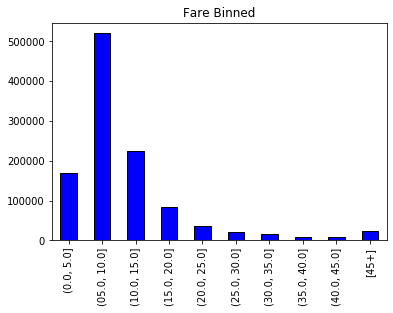

In [3]:
train_data['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Fare Binned');